Testing classificiation of primary endpoint type in datasets using MLP

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np # Don't think I need this but it's just habit at this point
import re
import string

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import nltk

In [3]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

For some reason, up til now I have yet to save a clean CSV file of the EUCT-NS dataset

In [3]:
# Load the untouched EUCT-NS dataset
df = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\untouched_euct_ns.csv', encoding='unicode_escape')

In [4]:
print(df.head())

       EudraCT_No                                              Title Phase  \
0  2018-003243-39  A Phase 3, Randomized, Double-Blind, Placebo-C...     3   
1  2009-016138-29  âRandomized, Multicenter, Open-label, Phase ...   iii   
2  2016-000474-38  A Multicenter, 2-Cohort Trial to First Assess ...     0   
3  2014-000418-75  A Multicenter, Multinational, Randomized, Doub...     0   
4  2012-002933-12  A Phase II pilot study to explore treatment wi...    ii   

                                           Objective   End_date  Sample_size  \
0  The primary purpose of this study is to evalua...        NaN          175   
1  To compare the efficacy of plitidepsin in comb...  20-Nov-17          255   
2  To demonstrate that fenfluramine hydrochloride...  05-Jun-18           87   
3  The primary objective of this study was to ass...  19-Jun-18          352   
4  To determine whether patients taking a medicin...  10-Dec-18            8   

                                         pr_endpoi

In [37]:
# Clean the data 
lemmatizer = WordNetLemmatizer()

In [22]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert to lower case
    text = text.split()  # Split into words
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]  # Lemmatize and remove stopwords # Get rid of primary as a stop word
    return ' '.join(text)

In [38]:
import unicodedata
def strip_accents(text):
    return ''. join(word for word in unicodedata.normalize ('NFD', text)
                     if unicodedata.category(word) != 'Mn')

In [24]:
df['Title'] = df['Title'].apply(preprocess_text)
df['Objective'] = df['Objective'].apply(preprocess_text)
df['pr_endpoint'] = df['pr_endpoint'].apply(preprocess_text)

In [25]:
df['endpoint_description'] = df['endpoint_description'].apply(str)
df['endpoint_description'] = df['endpoint_description'].apply(preprocess_text)
df['Title'] = df['Title'].apply(strip_accents)

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s2421127\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
def no_primary(text):
    stop = nltk.corpus.stopwords.words('english')
    stop.append("primary")
    return ' '.join([word for word in text.split() if word not in stop])

In [28]:
df['pr_endpoint'] = df['pr_endpoint'].apply(no_primary)

In [29]:
display(df.head())

,EudraCT_No,Title,Phase,Objective,End_date,Sample_size,pr_endpoint,endpoint_description,Treatment,LT_followup,manual_label
0,2018-003243-39,phase 3 randomized double blind placebo contro...,3,primary purpose study evaluate safety efficacy...,NaN,175,change baseline myasthenia gravis activity dai...,mg adl 8 point questionnaire focusing relevant...,Ravulizumab,No,0
1,2009-016138-29,randomized multicenter open label phase iii st...,iii,compare efficacy plitidepsin combination dexam...,20-Nov-17,255,progression free survival independent review c...,primary study analysis based externally assess...,Aplidin,No,2
2,2016-000474-38,multicenter 2 cohort trial first as pharmacoki...,0,demonstrate fenfluramine hydrochloride superio...,05-Jun-18,87,change convulsive seizure frequency csf baseli...,baseline adjusted csf mean number convulsive s...,fenfluramine hydrochloride,Yes,0
3,2014-000418-75,multicenter multinational randomized double bl...,0,primary objective study as efficacy laquinimod...,19-Jun-18,352,change baseline uhdrs tm week 52,uhdrs as motor function cognition behaviour fu...,Placebo,No,0
4,2012-002933-12,phase ii pilot study explore treatment sodium ...,ii,determine whether patient taking medicine call...,10-Dec-18,8,workload,participant cycled cycle ergometer oxygen cons...,Sodium Valproate,No,1


In [30]:
df.to_csv('euct_ns.csv', index=False)

Train the classifier

In [4]:
import joblib # Need this to save the fitted vectorizer when I apply it to the NS-HRA dataset

In [5]:
euct_ns = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\euct_ns.csv', encoding='unicode_escape')

In [6]:
text_columns = ['Title', 'Objective', 'pr_endpoint', 'endpoint_description']
X = euct_ns[text_columns] 
y = euct_ns['manual_label'].values

X is words so needs to be converted into numerical features

In [7]:
X = X[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
tfidf = TfidfVectorizer(ngram_range=(1,3))

In [10]:
X = tfidf.fit_transform(X)

In [11]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [12]:
joblib.dump(tfidf, 'tfidf_train.pkl')

['tfidf_train.pkl']

In [13]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler(with_mean=False) # Sparse dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
joblib.dump(scaler, 'scaler_train.pkl')

['scaler_train.pkl']

In [15]:
# Create an MLPClassifier model
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    max_iter=1000, random_state=3)

In [16]:
# Train the model on the training data
mlp.fit(X_train, y_train)

# Make predictions on the test data
y_pred = mlp.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 73.68%


In [61]:
print(y_test)

[0 0 2 0 0 0 2 2 2 2 1 0 0 0 0 0 0 1 2 1 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0
 0]


In [62]:
print(y_pred) # There is no cases of intermediate outcomes in the pred set. Do I re-run it?

[0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [46]:
# Generate a classification report
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\"class_report")

Classification Report:"class_report


c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

Apply MLP model to NS-HRA dataset

In [63]:
eleven = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra_11.csv', encoding='unicode_escape')
twelve = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra_12.csv', encoding='unicode_escape')
thirteen = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra_13.csv', encoding='unicode_escape')
fourteen = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra_14.csv', encoding='unicode_escape')
fifteen = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra_15.csv', encoding='unicode_escape')
sixteen = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra_16.csv', encoding='unicode_escape')
seventeen = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra_17.csv', encoding='unicode_escape')
eighteen = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra_18.csv', encoding='unicode_escape')
nineteen = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra_19.csv', encoding='unicode_escape')
twenty = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra_20.csv', encoding='unicode_escape')

In [64]:
ns_hra_untouched = pd.concat([eleven, twelve, thirteen, fourteen, fifteen, sixteen, seventeen, eighteen, nineteen, twenty], axis=0)

In [65]:
len(ns_hra_untouched)

694

In [66]:
ns_hra_untouched.to_csv('untouched_ns_hra.csv', index=False)

In [67]:
df = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\untouched_ns_hra.csv', encoding='unicode_escape')

In [68]:
display(df.head())

,Unique_ID,Title,Phase,Objective,End_date,Sample_size,1ry_endpoint,Treatment,LT_followup
0,IRAS_projectID_57754,"Phase II, multicenter, randomized, adaptive, d...",ii,To assess the efficacy and the safety of liqui...,31/05/2013 00:00,150.0,The primary outcome measure is the Motor Funct...,NaN,Subjects will participate in the study for a t...
1,IRAS_projectID_82035,"A Randomized, Controlled, Long-term Safety Stu...",0,The principal objective of the study is to ass...,30/09/2013 00:00,450.0,The primary endpoint in this study is the chan...,NaN,Subjects will be involved in this study for ju...
2,IRAS_projectID_64187,"A Randomized, Double-Blind, Double-Dummy, Para...",0,To assess whether the efficacy of Ocrelizumab ...,31/03/2015 00:00,800.0,The primary efficacy analysis for this trial w...,NaN,Screening 2 weeks\nTreatment phase 96 weeks\nS...
3,IRAS_projectID_72673,"Multi-Centre, Open-Label, Randomised Trial Inv...",0,To evaluate the pharmacokinetics (PK) of two d...,15/10/2011 00:00,10.0,Primary Endpoints: Pharmacokinetic Endpoints\n...,NaN,The subjectÃ¢ÂÂs participation in the trial ...
4,IRAS_projectID_67978,The use of carer assisted adherence therapy fo...,0,PRIMARY Aim:\nTo investigate if a seven week p...,NaN,120.0,The primary outcome measures for the study are...,NaN,Three to three and a half months for patients ...


In [70]:
df['Title'] = df['Title'].apply(str)

In [71]:
df['Title'] = df['Title'].apply(preprocess_text)
df['Objective'] = df['Objective'].apply(preprocess_text)
df['1ry_endpoint'] = df['1ry_endpoint'].apply(preprocess_text)

In [72]:
df['Title'] = df['Title'].apply(strip_accents)

In [73]:
df['1ry_endpoint'] = df['1ry_endpoint'].apply(no_primary)

In [74]:
display(df.head())

,Unique_ID,Title,Phase,Objective,End_date,Sample_size,1ry_endpoint,Treatment,LT_followup
0,IRAS_projectID_57754,phase ii multicenter randomized adaptive doubl...,ii,ass efficacy safety liquid suspension formulat...,31/05/2013 00:00,150.0,outcome measure motor function measure mfm d1 ...,NaN,Subjects will participate in the study for a t...
1,IRAS_projectID_82035,randomized controlled long term safety study e...,0,principal objective study ass long term safety...,30/09/2013 00:00,450.0,endpoint study change baseline total score nor...,NaN,Subjects will be involved in this study for ju...
2,IRAS_projectID_64187,randomized double blind double dummy parallel ...,0,ass whether efficacy ocrelizumab given two dos...,31/03/2015 00:00,800.0,efficacy analysis trial compare annualized pro...,NaN,Screening 2 weeks\nTreatment phase 96 weeks\nS...
3,IRAS_projectID_72673,multi centre open label randomised trial inves...,0,evaluate pharmacokinetics pk two different bat...,15/10/2011 00:00,10.0,endpoint pharmacokinetic endpoint pk endpoint ...,NaN,The subjectÃ¢ÂÂs participation in the trial ...
4,IRAS_projectID_67978,use carer assisted adherence therapy people pa...,0,primary aim investigate seven week programme c...,NaN,120.0,outcome measure study morisky medication asses...,NaN,Three to three and a half months for patients ...


In [75]:
df.to_csv('ns_hra.csv', index=False)

Make predictions of primary endpoint type on NS-HRA dataset

In [42]:
ns_hra = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra.csv', encoding='unicode_escape')

There's still some issues with the cleaning so I went back to here and fixed it. Re-run everything from here

In [91]:
def clean_text(text):
    if not isinstance(text, str):
        return text
    # Normalize text to remove accents
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    # Remove any non-ASCII characters
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

In [92]:
ns_hra['Title'] = ns_hra['Title'].apply(clean_text)
ns_hra['Objective'] = ns_hra['Objective'].apply(clean_text)
ns_hra['1ry_endpoint'] = ns_hra['1ry_endpoint'].apply(clean_text)

This is an issue with the original source document from where thedataset was formed. Extracting from XML files has a bunch of rubbish in the raw data

In [93]:
def remove_repetitions(text):
    if not isinstance(text, str):
        return text
    # Replace consecutive duplicate words (case insensitive)
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text, flags=re.IGNORECASE)
    return text

ns_hra['Title'] = ns_hra['Title'].apply(remove_repetitions)
ns_hra['Objective'] = ns_hra['Objective'].apply(remove_repetitions)
ns_hra['1ry_endpoint'] = ns_hra['1ry_endpoint'].apply(remove_repetitions)

In [94]:
ns_hra.head()

,Unique_ID,Title,Phase,Objective,End_date,Sample_size,1ry_endpoint,Treatment,LT_followup
0,IRAS_projectID_57754,phase ii multicenter randomized adaptive doubl...,ii,ass efficacy safety liquid suspension formulat...,31/05/2013 00:00,150.0,outcome measure motor function measure mfm d1 ...,NaN,Subjects will participate in the study for a t...
1,IRAS_projectID_82035,randomized controlled long term safety study e...,0,principal objective study ass long term safety...,30/09/2013 00:00,450.0,endpoint study change baseline total score nor...,NaN,Subjects will be involved in this study for ju...
2,IRAS_projectID_64187,randomized double blind double dummy parallel ...,0,ass whether efficacy ocrelizumab given two dos...,31/03/2015 00:00,800.0,efficacy analysis trial compare annualized pro...,NaN,Screening 2 weeks\nTreatment phase 96 weeks\nS...
3,IRAS_projectID_72673,multi centre open label randomised trial inves...,0,evaluate pharmacokinetics pk two different bat...,15/10/2011 00:00,10.0,endpoint pharmacokinetic endpoint pk endpoint ...,NaN,The subjectÃÂÃÂ¢ÃÂÃÂÃÂÃÂs participa...
4,IRAS_projectID_67978,use carer assisted adherence therapy people pa...,0,primary aim investigate seven week programme c...,NaN,120.0,outcome measure study morisky medication asses...,NaN,Three to three and a half months for patients ...


In [95]:
ns_hra.to_csv('ns_hra.csv', index=False)

In [17]:
ns_hra = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra.csv', encoding='unicode_escape')

Now this should be properly cleaned and I can re-run everything

In [18]:
vectorizer = joblib.load('tfidf_train.pkl')
scaler = joblib.load('scaler_train.pkl')

In [19]:
text_columns = ['Title', 'Objective', '1ry_endpoint'] # In the HRA REC forms, the primary endpoint and endpoint description are together
X2 = ns_hra[text_columns] 

In [20]:
X2 = X2[text_columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [21]:
X2 = vectorizer.transform(X2)

In [22]:
X2 = scaler.transform(X2) # I did this in the training so I guess I have to do that here

In [23]:
y_pred = mlp.predict(X2)

In [24]:
confidence_scores = mlp.predict_proba(X2) # How sure is the model on the predictions that it made?

In [25]:
euct_ns_pred = pd.DataFrame(confidence_scores, columns=['PFO_0', 'IO_1', 'SO_2'])
euct_ns_pred['Predicted_label'] = y_pred

In [26]:
print(euct_ns_pred.head())

      PFO_0      IO_1      SO_2  Predicted_label
0  0.966957  0.023504  0.009539                0
1  0.992628  0.005143  0.002228                0
2  0.998461  0.001181  0.000358                0
3  0.844298  0.087099  0.068603                0
4  0.961650  0.026418  0.011932                0


In [27]:
euct_ns_pred.to_csv('euct_ns_pred.csv', index=False)

Descriptive statistics
# Need to know what the hell is going on

In [28]:
# Data visualisation of clusters - t-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

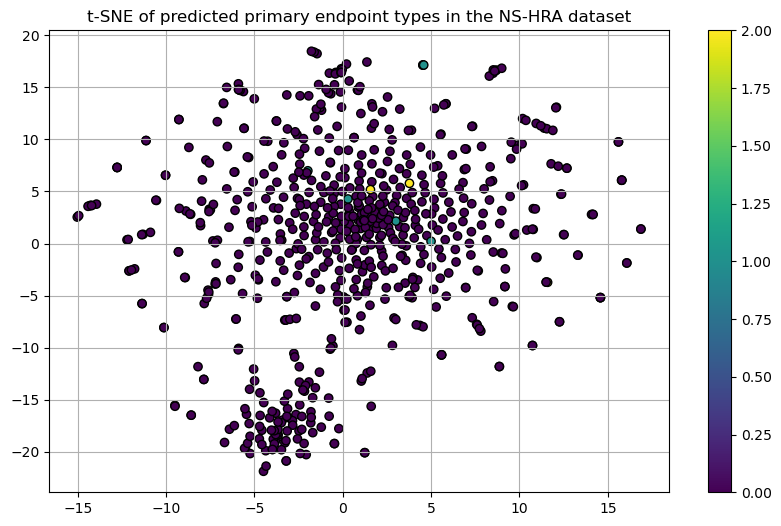

In [29]:
# Convert sparse matrix to dense
X2_dense = X2.toarray()

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X2_tsne = tsne.fit_transform(X2_dense)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X2_tsne[:, 0], X2_tsne[:, 1], c=y_pred, cmap='viridis', marker='o', edgecolor='k')
plt.title('t-SNE of predicted primary endpoint types in the NS-HRA dataset')
plt.colorbar(scatter)
plt.grid(True)
#plt.savefig('t-SNE of predicted primary endpoint types in the NS-HRA dataset')
plt.show()

In [30]:
# Slope chart for frequency distribution across different labels
pfo_df = ns_hra[y_pred == 0]
io_df = ns_hra[y_pred == 1]
so_df = ns_hra[y_pred == 2]

In [ ]:
pfo_df.head() #Sanity check

,Unique_ID,Title,Phase,Objective,End_date,Sample_size,1ry_endpoint,Treatment,LT_followup
0,IRAS_projectID_57754,phase ii multicenter randomized adaptive doubl...,ii,ass efficacy safety liquid suspension formulat...,31/05/2013 00:00,150.0,outcome measure motor function measure mfm d1 ...,NaN,Subjects will participate in the study for a t...
1,IRAS_projectID_82035,randomized controlled long term safety study e...,0,principal objective study ass long term safety...,30/09/2013 00:00,450.0,endpoint study change baseline total score nor...,NaN,Subjects will be involved in this study for ju...
2,IRAS_projectID_64187,randomized double blind double dummy parallel ...,0,ass whether efficacy ocrelizumab given two dos...,31/03/2015 00:00,800.0,efficacy analysis trial compare annualized pro...,NaN,Screening 2 weeks\nTreatment phase 96 weeks\nS...
3,IRAS_projectID_72673,multi centre open label randomised trial inves...,0,evaluate pharmacokinetics pk two different bat...,15/10/2011 00:00,10.0,endpoint pharmacokinetic endpoint pk endpoint ...,NaN,The subjectÃÂÃÂÃÂÃÂ¢ÃÂÃÂÃÂÃÂÃÂ...
4,IRAS_projectID_67978,use carer assisted adherence therapy people pa...,0,primary aim investigate seven week programme c...,NaN,120.0,outcome measure study morisky medication asses...,NaN,Three to three and a half months for patients ...


In [32]:
pfo_df = pfo_df.copy()
io_df = io_df.copy()
so_df = so_df.copy()

In [33]:
pfo_df['concat_corpus'] = pfo_df['Title']+ " " + pfo_df['Objective'] + " " + pfo_df['1ry_endpoint'] 
io_df['concat_corpus'] = io_df['Title']+ " " + io_df['Objective'] + " " + io_df['1ry_endpoint'] 
so_df['concat_corpus'] = so_df['Title']+ " " + so_df['Objective'] + " " +so_df['1ry_endpoint'] 

In [ ]:
pfo_df.head() #sanity check

,Unique_ID,Title,Phase,Objective,End_date,Sample_size,1ry_endpoint,Treatment,LT_followup,concat_corpus
0,IRAS_projectID_57754,phase ii multicenter randomized adaptive doubl...,ii,ass efficacy safety liquid suspension formulat...,31/05/2013 00:00,150.0,outcome measure motor function measure mfm d1 ...,NaN,Subjects will participate in the study for a t...,phase ii multicenter randomized adaptive doubl...
1,IRAS_projectID_82035,randomized controlled long term safety study e...,0,principal objective study ass long term safety...,30/09/2013 00:00,450.0,endpoint study change baseline total score nor...,NaN,Subjects will be involved in this study for ju...,randomized controlled long term safety study e...
2,IRAS_projectID_64187,randomized double blind double dummy parallel ...,0,ass whether efficacy ocrelizumab given two dos...,31/03/2015 00:00,800.0,efficacy analysis trial compare annualized pro...,NaN,Screening 2 weeks\nTreatment phase 96 weeks\nS...,randomized double blind double dummy parallel ...
3,IRAS_projectID_72673,multi centre open label randomised trial inves...,0,evaluate pharmacokinetics pk two different bat...,15/10/2011 00:00,10.0,endpoint pharmacokinetic endpoint pk endpoint ...,NaN,The subjectÃÂÃÂÃÂÃÂ¢ÃÂÃÂÃÂÃÂÃÂ...,multi centre open label randomised trial inves...
4,IRAS_projectID_67978,use carer assisted adherence therapy people pa...,0,primary aim investigate seven week programme c...,NaN,120.0,outcome measure study morisky medication asses...,NaN,Three to three and a half months for patients ...,use carer assisted adherence therapy people pa...


In [49]:
# Fill missing values with an empty string
so_df['concat_corpus'] = so_df['concat_corpus'].fillna('')

tfidf_matrix = vectorizer.fit_transform(so_df['concat_corpus'])
so_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
print(so_tfidf_df)

        10      11c  11c pbr28  11c pbr28 binding        12   12 week  \
0  0.00000  0.11613    0.11613            0.11613  0.058065  0.058065   
1  0.05353  0.00000    0.00000            0.00000  0.000000  0.000000   
2  0.00000  0.00000    0.00000            0.00000  0.000000  0.000000   

   12 week multicenter      120   120 mg  120 mg 200  ...  \
0             0.058065  0.00000  0.00000     0.00000  ...   
1             0.000000  0.05353  0.05353     0.05353  ...   
2             0.000000  0.00000  0.00000     0.00000  ...   

   week multicenter randomized    weight  weight clinical  \
0                     0.058065  0.058065         0.058065   
1                     0.000000  0.000000         0.000000   
2                     0.000000  0.000000         0.000000   

   weight clinical laboratory      well  well clinical  \
0                    0.058065  0.000000       0.000000   
1                    0.000000  0.000000       0.000000   
2                    0.000000  0.049988    

In [50]:
so_tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).ravel()

In [51]:
feature_names = vectorizer.get_feature_names_out()

In [52]:
so_tfidf_df_list = pd.DataFrame({'word': feature_names, 'tfidf_score': so_tfidf_scores})

In [53]:
so_tfidf = so_tfidf_df_list.sort_values(by='tfidf_score', ascending=False)

In [54]:
 top_n = 618

In [55]:
so_tfidf.head(top_n).to_csv('tf-idf so.csv', index=False)

In [56]:
pfo_tfidf_df = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\tf-idf pfo.csv', encoding='unicode_escape')
io_tfidf_df = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\tf-idf io.csv', encoding='unicode_escape')
so_tfidf_df = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\tf-idf so.csv', encoding='unicode_escape')

In [57]:
merged_df = pfo_tfidf_df.merge(io_tfidf_df, on='word', suffixes=('_pfo', '_io'))
merged_df = merged_df.merge(so_tfidf_df, on='word')
merged_df.rename(columns={'tfidf_score': 'tfidf_score_so'}, inplace=True)

In [ ]:
merged_df.head()
# The first one is clearly a problem with the structure of XML files and i've cleaned as best as I can google. I'll just delete row 1.

,word,tfidf_score_pfo,tfidf_score_io,tfidf_score_so
0,aa,0.020847,0.053081,0.054785
1,study,0.019491,0.051614,0.051494
2,patient,0.018032,0.057843,0.033326
3,safety,0.017098,0.047472,0.043242
4,placebo,0.015734,0.043031,0.016663


In [69]:
merged_df = merged_df.iloc[1:]
merged_df = merged_df.copy()

In [70]:
merged_df['max_diff'] = merged_df[['tfidf_score_pfo', 'tfidf_score_io', 'tfidf_score_so']].max(axis=1) - \
                        merged_df[['tfidf_score_pfo', 'tfidf_score_io', 'tfidf_score_so']].min(axis=1)

sorted_df = merged_df.sort_values(by='max_diff', ascending=False)

top_features_df = sorted_df.head(15)
print(top_features_df)

             word  tfidf_score_pfo  tfidf_score_io  tfidf_score_so  max_diff
66             13         0.000679        0.018679        0.083314  0.082635
6        efficacy         0.014884        0.088027        0.040065  0.073142
26             mg         0.007680        0.020939        0.071373  0.063693
9         subject         0.012116        0.070956        0.028290  0.058840
61          state         0.001296        0.013567        0.053530  0.052234
31       measured         0.006588        0.018280        0.057730  0.051142
19         effect         0.009084        0.018181        0.058065  0.048981
11           dose         0.011885        0.009090        0.053530  0.044439
2         patient         0.018032        0.057843        0.033326  0.039812
50             10         0.003144        0.041028        0.017843  0.037884
47       severity         0.003651        0.013567        0.038710  0.035059
57   rating scale         0.001981        0.036560        0.019355  0.034579

In [71]:
top_features_df = top_features_df.copy()

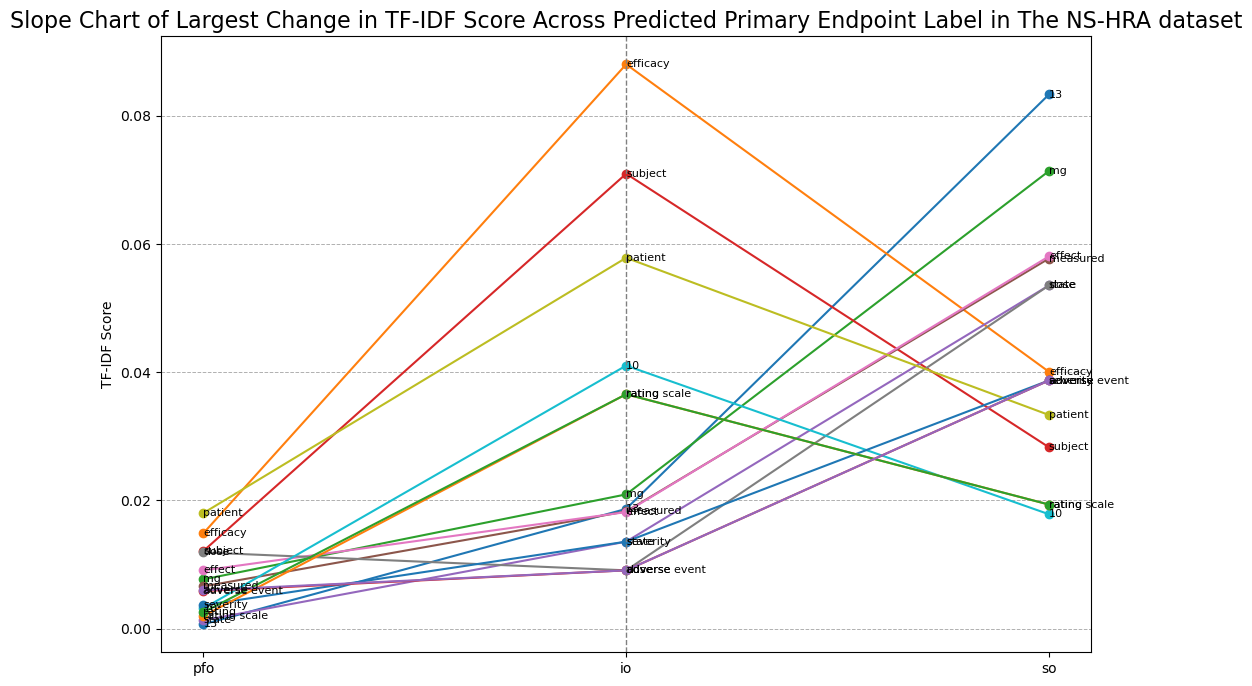

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))

jitter_strength = 0.4

for i in range(len(top_features_df)):
    x_positions = np.array([0, 1, 2]) + np.random.normal(0, jitter_strength, size=3)
    ax.plot(['pfo', 'io', 'so'], 
            [top_features_df.iloc[i]['tfidf_score_pfo'], top_features_df.iloc[i]['tfidf_score_io'], top_features_df.iloc[i]['tfidf_score_so']],
            marker='o', label=top_features_df['word'].iloc[i])

for i, word in enumerate(top_features_df['word']):
    for j, subset in enumerate(['pfo', 'io', 'so']):
        ax.text(j, top_features_df.iloc[i, j+1], f'{word}', verticalalignment='center', fontsize=8)

ax.axvline(x=1, color='gray', linestyle='--', linewidth=1) 

# Customize the plot
ax.set_title('Slope Chart of Largest Change in TF-IDF Score Across Predicted Primary Endpoint Label in The NS-HRA dataset', fontsize=16)
ax.set_ylabel('TF-IDF Score')
ax.set_xticks(['pfo', 'io', 'so'])
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

# Display the slope chart
plt.show()

In [ ]:
# Correlation matrix of TF-IDF scores

In [77]:
concordance_df = merged_df[['word', 'tfidf_score_pfo', 'tfidf_score_io', 'tfidf_score_so']]
correlation_matrix = concordance_df[['tfidf_score_pfo', 'tfidf_score_io', 'tfidf_score_so']].corr()
print(correlation_matrix)

                 tfidf_score_pfo  tfidf_score_io  tfidf_score_so
tfidf_score_pfo         1.000000        0.625713        0.157623
tfidf_score_io          0.625713        1.000000        0.063594
tfidf_score_so          0.157623        0.063594        1.000000


In [78]:
import seaborn as sns

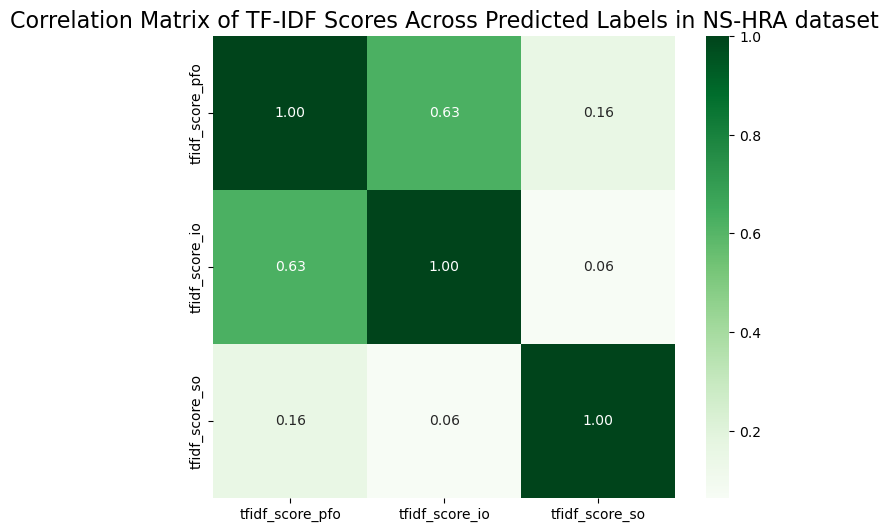

In [80]:
plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Greens', square=True)

plt.title('Correlation Matrix of TF-IDF Scores Across Predicted Labels in NS-HRA dataset', fontsize=16)
plt.show()